In [3]:
%load_ext rpy2.ipython

from cap2.capalyzer.pangea import PangeaFileSource
from cap2.capalyzer.pangea.utils import get_pangea_group

from plotnine import *
import pandas as pd
import warnings
from glob import glob
from os.path import isfile
from os import environ

warnings.filterwarnings('ignore')

twins_group = get_pangea_group('Mason Lab', 'NASA Twins', 'dcdanko@gmail.com', environ.get('PANGEA_PASS'))
twins_source = PangeaFileSource(twins_group)


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
filepaths = list(twins_source('cap2::experimental::make_snp_clusters', 'snp_clusters__Chryseobacterium_indoltheticum'))

In [6]:
filepaths

[('011515_TW_B',
  '/home/dcdanko/Data/cap_tmp/011515_TW_B.cap2__experimental__make_snp_clusters.snp_clusters__Chryseobacterium_indoltheticum.csv.gz'),
 ('011515_TW_S',
  '/home/dcdanko/Data/cap_tmp/011515_TW_S.cap2__experimental__make_snp_clusters.snp_clusters__Chryseobacterium_indoltheticum.csv.gz'),
 ('012015_HR_B',
  '/home/dcdanko/Data/cap_tmp/012015_HR_B.cap2__experimental__make_snp_clusters.snp_clusters__Chryseobacterium_indoltheticum.tsv.gz'),
 ('012015_HR_S',
  '/home/dcdanko/Data/cap_tmp/012015_HR_S.cap2__experimental__make_snp_clusters.snp_clusters__Chryseobacterium_indoltheticum.csv.gz'),
 ('012016_HR_B',
  '/home/dcdanko/Data/cap_tmp/012016_HR_B.cap2__experimental__make_snp_clusters.snp_clusters__Chryseobacterium_indoltheticum.csv.gz'),
 ('012016_HR_S',
  '/home/dcdanko/Data/cap_tmp/012016_HR_S.cap2__experimental__make_snp_clusters.snp_clusters__Chryseobacterium_indoltheticum.csv.gz'),
 ('012715_TW_B',
  '/home/dcdanko/Data/cap_tmp/012715_TW_B.cap2__experimental__make_snp_

In [35]:

class SNPBarcode:
    
    def __init__(self, tbl):
        self.tbl = tbl
        self.sample_name = tbl['sample_name'].unique()[0]
        self.seq = tbl['seq'].unique()[0]
        self.snps = set(zip(tbl['coord'], tbl['changed']))

    def __len__(self):
        return len(self.snps)
        


def barcode_barcode_similarity(b1, b2):
    if b1.seq != b2.seq:
        return 0
    jaccard = len(b1.snps & b2.snps) / len(b1.snps | b2.snps)
    return jaccard
    


def parse_snp_clusters(sample_name, filepath):
    tbl = pd.read_csv(filepath, compression='gzip', index_col=0)
    tbl = tbl.query('weight >= 10')
    tbl['sample_name'] = sample_name
    barcodes = [bc for bc in tbl.groupby('cluster').apply(SNPBarcode) if len(bc) >= 5]
    return barcodes
    
b1 = parse_snp_clusters('MHV-twin-4_S41677925', '/home/dcdanko/Data/cap_tmp/MHV-twin-4_S41677925.cap2__experimental__make_snp_clusters.snp_clusters__Chryseobacterium_indoltheticum.csv.gz')
b2 = parse_snp_clusters('MHV-twin-3_S41658396', '/home/dcdanko/Data/cap_tmp/MHV-twin-3_S41658396.cap2__experimental__make_snp_clusters.snp_clusters__Chryseobacterium_indoltheticum.csv.gz')

len(b1), len(b2)

(6245, 12588)

In [51]:
barcode_sets = [(sample_name, parse_snp_clusters(sample_name, filepath)) for sample_name, filepath in filepaths]

In [53]:
import networkx as nx

G = nx.Graph()

bsets = barcode_sets  #[:3]

for sample_name, bset in bsets:
    nodes = list(G.nodes())
    comps = [comp for comp in nx.connected_components(G) if len(comp) >= 2]
    print(sample_name, len(nodes), len(comps))
    for barcode in bset:
        for node in nodes:
            d = barcode_barcode_similarity(barcode, node)
            if d >= 0.5:
                G.add_edge(barcode, node)
    for barcode in bset:
        G.add_node(barcode)
                


011515_TW_B 0 0
011515_TW_S 6255 0
012015_HR_B 17753 769
012015_HR_S 22112 1156
012016_HR_B 39325 3033
012016_HR_S 51922 5714
012715_TW_B 63490 14423
012715_TW_S 63664 14444
030116_TW_B 63968 14501
030116_TW_S 66399 14873
040616_TW_B 72944 15924
041015_TW_B 85567 23859
041015_TW_S 85714 23882
050616_HR_B 102928 36637
061115_TW_B 104312 36738
061115_TW_S 108742 39956
061416_TW_S 125928 39931
071716_HR_B 143169 39956
073015_HR_B 160406 39980
073015_HR_S 160538 40003
082916_HR_B 160864 40035
082916_HR_S 160933 40050
100215_HR_S 171438 40317
120314_HR_B 176167 40499
120314_HR_S 180607 40532
121015_TW_B 193189 40703
MHV-HR2_S41666347 193792 40754
MHV-HR3_S41658400 193919 40777
MHV-HR4_S41677053 206434 40776
MHV-HR5_S41659407 223672 40777
MHV-HR6_S41664399 225042 41665
MHV-HR7_S41668198 225203 41664
MHV-HR8_S41669183 242442 41663
MHV-HR9_S41667391 259658 41660
MHV-TW1_S41667392 262135 42552
MHV-TW2_S41668201 279330 42535
MHV-TW3_S41666352 285877 45059
MHV-TW4_S41665304 286006 45063
MHV-TW5_S

In [54]:
comps = [comp for comp in nx.connected_components(G) if len(comp) >= 2]
len(comps)

54694

In [55]:
import networkx as nx


class SNPBarcode:

    def __init__(self, tbl):
        self.tbl = tbl
        self.sample_name = tbl['sample_name'].unique()[0]
        self.seq = tbl['seq'].unique()[0]
        self.snps = set(zip(tbl['coord'], tbl['changed']))

    def __len__(self):
        return len(self.snps)


class SNPBarcodeSet:

    def __init__(self):
        self.seq = None
        self.snps = set([])
        self.barcodes = []

    def __len__(self):
        return len(self.snps)

    def add_barcode(self, bc):
        if self.seq:
            assert bc.seq == self.seq
        else:
            self.seq = bc.seq
        self.snps |= bc.snps
        self.barcodes.append(bc)
        return self


def barcode_barcode_similarity(b1, b2):
    if b1.seq != b2.seq:
        return 0
    jaccard = len(b1.snps & b2.snps) / len(b1.snps | b2.snps)
    return jaccard


def barcode_barcode_set_similarity(bc, bc_set):
    if bc.seq != bc_set.seq:
        return 0
    jaccard = len(bc.snps & bc_set.snps) / len(bc.snps)
    return jaccard


def build_barcode_sets(barcodes, sim_thresh=0.5):
    """Return a list of SNPBarcodeSets that fulfill sevreal reqs.

     - all barcodes are in one or more barcode sets
     - each barcode in a set has similarity of at least sim_thresh to that set
    """
    barcode_sets = []
    for i, bc in enumerate(barcodes):
        if i % 1000 == 0:
            print(i, len(barcode_sets))
        added_to_bc_set = False
        for bc_set in barcode_sets:
            s = barcode_barcode_set_similarity(bc, bc_set)
            if s < sim_thresh:
                continue
            added_to_bc_set = True
            bc_set.add_barcode(bc)
        if not added_to_bc_set:
            new_bc_set = SNPBarcodeSet().add_barcode(bc)
            barcode_sets.append(new_bc_set)
    return barcode_sets


def barcode_barcode_similarity_graph(barcodes, sim_thresh=0.5):
    """Return a Graph with edges between similar barcodes.

    - Barcodes with no similar barcdoes are not included
    - weight of each edge is the similarity
    """
    barcode_sets = build_barcode_sets(barcodes, sim_thresh=sim_thresh)
    G = nx.Graph()
    for bc_set in barcode_sets:
        for bc1 in bc_set.barcodes:
            for bc2 in bc_set.barcodes:
                if bc1 == bc2:
                    break
                s = barcode_barcode_similarity(bc1, bc2)
                if s >= sim_thresh:
                    G.add_edge(bc1, bc2, weight=s)
    return G


barcodes = []
for _, bset in barcode_sets:
    barcodes += bset

G = barcode_barcode_similarity_graph(barcodes)


0 0
1000 1000
2000 2000
3000 3000
4000 4000
5000 5000
6000 6000
7000 6888
8000 7726
9000 8588
10000 9456
11000 10328
12000 11175
13000 12030
14000 12900
15000 13738
16000 14606
17000 15583
18000 16363
19000 16865
20000 17636
21000 18354
22000 19073
23000 19811
24000 20571
25000 21356
26000 22132
27000 22918
28000 23711
29000 24479
30000 25136
31000 25823
32000 26651
33000 27506
34000 28355
35000 29158
36000 29978
37000 30768
38000 31570
39000 32375
40000 32880
41000 33380
42000 33883
43000 34384
44000 34887
45000 35382
46000 35875
47000 36293
48000 36729
49000 37151
50000 37620
51000 38058
52000 38395
53000 38395
54000 38395
55000 38395
56000 38395
57000 38395
58000 38395
59000 38395
60000 38395
61000 38395
62000 38395
63000 38395
64000 38540
65000 38624
66000 38718
67000 38860
68000 39053
69000 39235
70000 39417
71000 39601
72000 39795
73000 40008
74000 40008
75000 40008
76000 40008
77000 40008
78000 40008
79000 40008
80000 40008
81000 40008
82000 40008
83000 40008
84000 40008
85000 4

In [56]:
comps = [comp for comp in nx.connected_components(G) if len(comp) >= 2]
len(comps)

54694

In [39]:
dists = []
for a in b1:
    for b in b2:
        d = barcode_barcode_similarity(a, b)
        if d > 0:
            dists.append(d)
dists = pd.Series(dists)

dists

0       0.377246
1       0.211082
2       0.255754
3       0.041667
4       0.181592
          ...   
4683    0.385417
4684    0.222222
4685    0.379518
4686    0.311404
4687    0.369863
Length: 4688, dtype: float64

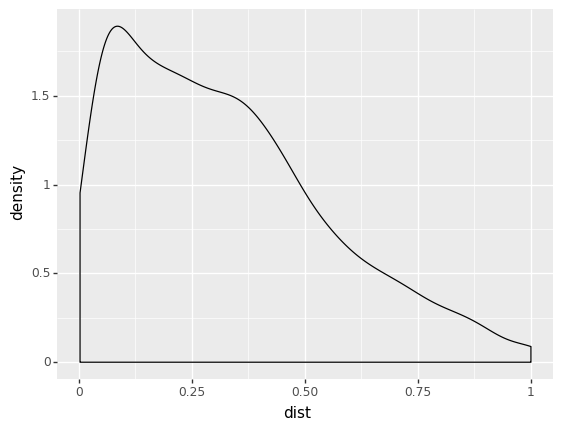

<ggplot: (8747610964758)>

In [41]:
t = pd.DataFrame.from_dict({'dist': dists})
(
    ggplot(t, aes(x='dist')) +
        geom_density()
)

mean 61.87951807228916
sd 69.466678727455
median 34.0
max 266
min 2


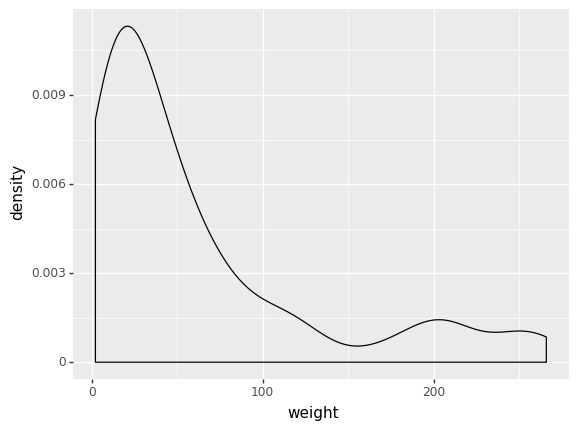

<ggplot: (-9223363289234453879)>

In [15]:
t = tbl
t = t.query('cluster == 0')


def plot_weights(tbl):
    return (
        ggplot(tbl, aes(x='weight')) +
            geom_density()
    )

print('mean', t['weight'].mean())
print('sd', t['weight'].std())
print('median', t['weight'].median())
print('max', t['weight'].max())
print('min', t['weight'].min())

plot_weights(t)

In [28]:
t.query('weight >= 10')

,changed,cluster,coord,original,seq,weight,sample_name
0,A,0,48611,T,NZ_JVIM01000013.1,15,MHV-twin-4_S41677925
1,G,0,48608,T,NZ_JVIM01000013.1,32,MHV-twin-4_S41677925
2,G,0,48612,T,NZ_JVIM01000013.1,17,MHV-twin-4_S41677925
3,C,0,48623,T,NZ_JVIM01000013.1,49,MHV-twin-4_S41677925
4,C,0,48631,A,NZ_JVIM01000013.1,218,MHV-twin-4_S41677925
...,...,...,...,...,...,...,...
73,T,0,48766,G,NZ_JVIM01000013.1,10,MHV-twin-4_S41677925
74,G,0,48775,C,NZ_JVIM01000013.1,10,MHV-twin-4_S41677925
75,T,0,48779,A,NZ_JVIM01000013.1,10,MHV-twin-4_S41677925
76,C,0,48787,T,NZ_JVIM01000013.1,10,MHV-twin-4_S41677925
